# Training Details

Increment Order

**Flowers-WikiArt-Sketch-Cars-CUB**

Dataset splits, augmentation, crops, and etc. : PiggyBack

Model: ImageNet pre-trained ResNet 50

Epochs: 30

Batchsize: 32

GPU type: Single GPU


### Layer-wise L1
src: https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch

### L1 on entire model
src: https://androidkt.com/how-to-add-l1-l2-regularization-in-pytorch-loss-function/

In [1]:
!nvidia-smi

Tue Feb 21 09:22:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:01:00.0 Off |                  Off |
| 30%   29C    P8    20W / 300W |  20990MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:25:00.0 Off |                  Off |
| 30%   

*Code Writer: Chaeeun Ryu*

*Contact: superbunny38 at gmail dot com*

# Import Libraries

In [2]:
# from options import options
import torchvision.models as models
import torchvision
import os
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
# from utils import create_transforms
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
# from torch.utils.tensorboard import SummaryWriter
import numpy as np
# import datasets
# from datasets import Scale
import timm
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

device =  torch.device('cuda:6')
device

device(type='cuda', index=6)

# Config 

Source: (http://172.23.100.138:9002/edit/src/CH/SOTA/TAPS/options.py)

In [3]:
from dataclasses import dataclass
@dataclass
class ARGS():
    LR = .01
    EPOCHS = 30
    BATCHSIZE = 32
    MOMENTUM = 0.9
    WORKERS = 8
    RESIZE = 256
    WEIGHTDECAY = 0
    EVAL_FREQ = 2
    TRIALS = 10
args = ARGS()
save_experiment = dict()

# Prepare Data

In [4]:
import os.path as osp
import os
from PIL import Image
import numpy as np

import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class MetaDataSet(Dataset):

    def __init__(self, root):
        data = []
        label = []
        lb = 0

        self.wnids = []
        folders = os.listdir(root)
        for folder in folders:
            folder_path = os.path.join(root, folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                data.append(file_path)
                label.append(lb)
            lb += 1


        self.data = data
        self.label = label

        self.tf = create_train_transform()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        path, label = self.data[i], self.label[i]
        image = self.tf(Image.open(path).convert('RGB'))
        return image, label

def create_train_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
    return train_tf

def create_test_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    test_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    return test_tf

class CategoriesSampler():
    #Taken from: https://github.com/yinboc/prototypical-network-pytorch/blob/master/samplers.py
    def __init__(self, label, n_batch, n_cls, n_per):
        self.n_batch = n_batch
        self.n_cls = n_cls
        self.n_per = n_per

        label = np.array(label)
        self.m_ind = []
        for i in range(max(label) + 1):
            ind = np.argwhere(label == i).reshape(-1)
            ind = torch.from_numpy(ind)
            self.m_ind.append(ind)

    def __len__(self):
        return self.n_batch
    
    def __iter__(self):
        for i_batch in range(self.n_batch):
            batch = []
            classes = torch.randperm(len(self.m_ind))[:self.n_cls]
            for c in classes:
                l = self.m_ind[c]
                pos = torch.randperm(len(l))[:self.n_per]
                batch.append(l[pos])
            batch = torch.stack(batch).t().reshape(-1)
            yield batch

In [5]:
!pwd

/workspace/src/CH/SOTA


In [6]:
data_name = "flowers"
train_path = f"/workspace/src/CH/SOTA/data/{data_name}/train/"
test_path = f"/workspace/src/CH/SOTA/data/{data_name}/test/"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

train_dataset = torchvision.datasets.ImageFolder(train_path, transform = train_transform)
val_dataset = torchvision.datasets.ImageFolder(test_path, transform = test_transform)
flowers_classes = len(train_dataset.classes)
print(data_name,flowers_classes)
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.BATCHSIZE, shuffle=True,
        num_workers=args.WORKERS, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=args.BATCHSIZE, shuffle=True,
    num_workers=args.WORKERS, pin_memory=True)

flowers 102


In [7]:
sample_img, sample_label = next(iter(train_loader))
print("train img size:",sample_img.size())
sample_img, sample_label = next(iter(val_loader))
print("val img size:",sample_img.size())

train img size: torch.Size([32, 3, 224, 224])
val img size: torch.Size([32, 3, 224, 224])


# Get ResNet-50 weights

In [8]:
from torchvision.models import resnet50, ResNet50_Weights

#### Check data names

In [9]:
global data_names 
sorted(os.listdir("/workspace/src/CH/SOTA/data/"))[2:]

['cubs_cropped', 'flowers', 'sketches', 'stanford_cars_cropped', 'wikiart']

# Define dict for classes per data

In [10]:
global data_classes 
data_classes = {"cubs_cropped":200,"flowers":102,"sketches":250, "stanford_cars_cropped":196, "wikiart":195}

# Build ResNet-50

In [11]:
'''ResNet in PyTorch.
Reference:
https://github.com/kuangliu/pytorch-cifar
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace = True) 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         print("block.expansion:",block.expansion) == 1
#         self.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.task_specific_fcs = dict()
        for data_name,data_class in data_classes.items():
            self.task_specific_fcs[data_name] = nn.Linear(512*block.expansion,data_class)
            
#         self.linear = nn.Linear(8192, num_classes)
        

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x,data_name = "",device = device):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out1 = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
#         out = F.avg_pool2d(out4, 4)
        out = self.avgpool(out4)
        out = out.view(out.size(0), -1)
        out = self.task_specific_fcs[data_name].to(device)(out)
        return out, [out1, out2, out3, out4]


def ResNet50(num_classes):
    return ResNet(Bottleneck, [3,4,6,3],num_classes)

In [12]:
model = ResNet50(data_classes["flowers"])#.load_state_dict(resnet50(pretrained=ResNet50_Weights.IMAGENET1K_V2).state_dict())
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

# Load pretrained weight

In [13]:
from torchvision import models
pretrained_model = models.resnet50(pretrained=ResNet50_Weights.IMAGENET1K_V2)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Extract copied weights

In [14]:
import copy
model_weight = copy.deepcopy(model.state_dict())
pretrained_model_weight = copy.deepcopy(pretrained_model.state_dict())

In [15]:
import copy
idx = 0
for name, pretrained_weight in zip(model.state_dict().keys(),pretrained_model_weight.values()):
    if idx == 318 or idx == 319:
        pass
    else:
        print(name)
        assert model_weight[name].size() == pretrained_weight.size()
        model_weight[name] = pretrained_weight
    idx+=1

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.bn3.running_mean
layer1.0.bn3.running_var
layer1.0.bn3.num_batches_tracked
layer1.0.shortcut.0.weight
layer1.0.shortcut.1.weight
layer1.0.shortcut.1.bias
layer1.0.shortcut.1.running_mean
layer1.0.shortcut.1.running_var
layer1.0.shortcut.1.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer1

#### Load weight

In [16]:
model.load_state_dict(model_weight)

<All keys matched successfully>

#### Check if successfully loaded

In [17]:
idx = 0
for name, pretrained_weight in zip(model.state_dict().keys(),pretrained_model.state_dict().values()):
    if torch.equal(model.state_dict()[name],pretrained_weight) == True:
        pass
    else:
        print(idx)
#         model.state_dict()[name] = pretrained_weight
    idx+=1

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

# Settings

In [19]:
criterion = nn.CrossEntropyLoss().to(device)
best_val_top1_err = 100

optimizer = torch.optim.SGD(model.parameters(), 0.005,
                            momentum=0.9,
                            weight_decay=0)

scheduler = CosineAnnealingLR(optimizer, T_max = 25)

# Utils

In [20]:
def train(train_loader, model, criterion, optimizer, device, epoch, data_name = ""):
    losses = []#AverageMeter('Loss', ':.4e')
    top1 = []#AverageMeter('Acc@1', ':6.2f')
    model.train()
    # switch to train mode
    for i, (x, label) in tqdm(enumerate(train_loader),desc = "training..."):
        # measure data loading time
        x = x.to(device)
        label = label.to(device)

        # compute output
        output,_ = model(x,data_name)
#         print(output
        
        loss = criterion(output, label)
        preds = torch.argmax(output,dim=1)
#         print("pred:",preds)
#         print("label:",label)
        # measure accuracy and record loss
        acc1 = (torch.sum((preds==label)*1)/len(preds)).item()
        losses.append(loss.item())
        top1.append(acc1)

        # compute gradient and do SGD step
        loss.backward()
        if i % 8 == 0:
            optimizer.step()
            optimizer.zero_grad()
#     print(top1)
#     print(losses)
    return np.mean(top1),np.mean(losses)

def eval(val_loader, model, criterion, device,data_name):
    losses = []#AverageMeter('Loss', ':.4e')
    top1 = []#AverageMeter('Acc@1', ':6.2f')
    model.eval()
    with torch.no_grad():
        for i, (x, label) in enumerate(val_loader):
            x = x.to(device)
            label = label.to(device)
            
            
            # compute output
            output,_ = model(x,data_name)
    #         print(output

            loss = criterion(output, label)
            preds = torch.argmax(output,dim=1)
    #         print("pred:",preds)
    #         print("label:",label)
            # measure accuracy and record loss
            acc1 = (torch.sum((preds==label)*1)/len(preds)).item()
            losses.append(loss.item())
            top1.append(acc1)

    return np.mean(top1),np.mean(losses)


# [ Train Sequentially in conventional CL setting]

# Train on Flowers data

In [21]:
for idx,param in enumerate(model.parameters()):
    param.requires_grad = True

In [22]:
for name,weight in model.state_dict().items():
    print("\nname:",name)
    print(weight.size())


name: conv1.weight
torch.Size([64, 3, 7, 7])

name: bn1.weight
torch.Size([64])

name: bn1.bias
torch.Size([64])

name: bn1.running_mean
torch.Size([64])

name: bn1.running_var
torch.Size([64])

name: bn1.num_batches_tracked
torch.Size([])

name: layer1.0.conv1.weight
torch.Size([64, 64, 1, 1])

name: layer1.0.bn1.weight
torch.Size([64])

name: layer1.0.bn1.bias
torch.Size([64])

name: layer1.0.bn1.running_mean
torch.Size([64])

name: layer1.0.bn1.running_var
torch.Size([64])

name: layer1.0.bn1.num_batches_tracked
torch.Size([])

name: layer1.0.conv2.weight
torch.Size([64, 64, 3, 3])

name: layer1.0.bn2.weight
torch.Size([64])

name: layer1.0.bn2.bias
torch.Size([64])

name: layer1.0.bn2.running_mean
torch.Size([64])

name: layer1.0.bn2.running_var
torch.Size([64])

name: layer1.0.bn2.num_batches_tracked
torch.Size([])

name: layer1.0.conv3.weight
torch.Size([256, 64, 1, 1])

name: layer1.0.bn3.weight
torch.Size([256])

name: layer1.0.bn3.bias
torch.Size([256])

name: layer1.0.bn3.ru

In [23]:
!pwd

/workspace/src/CH/SOTA


In [24]:
experiment_path = "/workspace/src/CH/SOTA/wo_fixed_log/"

In [25]:
data_name

'flowers'

In [26]:
import copy
model.to(device)
best_val_acc = 0.
save_train_acc = []
save_val_acc = []
save_train_loss= []
save_val_loss = []
print("Data name:",data_name)
for epoch in tqdm(range(0, args.EPOCHS + 1)):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, device, epoch,data_name)
    if epoch <26:
        print(f"epoch: {epoch} skip validation (train acc: {train_acc})")
        continue
    val_acc,val_loss = eval(val_loader, model, criterion, device,data_name)
    save_train_acc.append(train_acc)
    save_val_acc.append(val_acc)
    save_train_loss.append(train_loss)
    save_val_loss.append(val_loss)
    print(f"epoch:{epoch} train acc:{train_acc} val acc:{val_acc}")
    state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer':optimizer.state_dict(),
    'train_acc':train_acc,
    'val_acc':val_acc,   
    }

    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_model_path = (f'{experiment_path}/init_model_best_epoch{epoch}.pth')
        #print(f"epoch {epoch}: best model updated")
        print("train acc:",train_acc, "val_acc:",val_acc)
        #torch.save(state, best_model_path)
        best_model = copy.deepcopy(model)

    opt_state = {
        'optimizer': optimizer.state_dict(),
    }
    scheduler.step()
# save_experiment["init"] = {'save_train_acc':save_train_acc,'save_val_acc':save_val_acc,'save_train_loss':save_train_loss,'save_val_loss':save_val_loss}

Data name: flowers


  0%|          | 0/31 [00:00<?, ?it/s]

training...: 0it [00:00, ?it/s]

epoch: 0 skip validation (train acc: 0.03076171875)


training...: 0it [00:00, ?it/s]

epoch: 1 skip validation (train acc: 0.3214518232271075)


training...: 0it [00:00, ?it/s]

epoch: 2 skip validation (train acc: 0.5641276044771075)


training...: 0it [00:00, ?it/s]

epoch: 3 skip validation (train acc: 0.6627604169771075)


training...: 0it [00:00, ?it/s]

epoch: 4 skip validation (train acc: 0.75439453125)


training...: 0it [00:00, ?it/s]

epoch: 5 skip validation (train acc: 0.8173828125)


training...: 0it [00:00, ?it/s]

epoch: 6 skip validation (train acc: 0.86181640625)


training...: 0it [00:00, ?it/s]

epoch: 7 skip validation (train acc: 0.904622396454215)


training...: 0it [00:00, ?it/s]

epoch: 8 skip validation (train acc: 0.931640625)


training...: 0it [00:00, ?it/s]

epoch: 9 skip validation (train acc: 0.94287109375)


training...: 0it [00:00, ?it/s]

epoch: 10 skip validation (train acc: 0.956380208954215)


training...: 0it [00:00, ?it/s]

epoch: 11 skip validation (train acc: 0.9523111982271075)


training...: 0it [00:00, ?it/s]

epoch: 12 skip validation (train acc: 0.9482421875)


training...: 0it [00:00, ?it/s]

epoch: 13 skip validation (train acc: 0.966634115204215)


training...: 0it [00:00, ?it/s]

epoch: 14 skip validation (train acc: 0.966145833954215)


training...: 0it [00:00, ?it/s]

epoch: 15 skip validation (train acc: 0.96240234375)


training...: 0it [00:00, ?it/s]

epoch: 16 skip validation (train acc: 0.9698893232271075)


training...: 0it [00:00, ?it/s]

epoch: 17 skip validation (train acc: 0.9677734375)


training...: 0it [00:00, ?it/s]

epoch: 18 skip validation (train acc: 0.9677734375)


training...: 0it [00:00, ?it/s]

epoch: 19 skip validation (train acc: 0.968587240204215)


training...: 0it [00:00, ?it/s]

epoch: 20 skip validation (train acc: 0.9677734375)


training...: 0it [00:00, ?it/s]

epoch: 21 skip validation (train acc: 0.9765625)


training...: 0it [00:00, ?it/s]

epoch: 22 skip validation (train acc: 0.970052083954215)


training...: 0it [00:00, ?it/s]

epoch: 23 skip validation (train acc: 0.9765625)


training...: 0it [00:00, ?it/s]

epoch: 24 skip validation (train acc: 0.97314453125)


training...: 0it [00:00, ?it/s]

epoch: 25 skip validation (train acc: 0.972005208954215)


training...: 0it [00:00, ?it/s]

epoch:26 train acc:0.96826171875 val acc:0.9470531088082902
train acc: 0.96826171875 val_acc: 0.9470531088082902


training...: 0it [00:00, ?it/s]

epoch:27 train acc:0.975911458954215 val acc:0.9478626943005182
train acc: 0.975911458954215 val_acc: 0.9478626943005182


training...: 0it [00:00, ?it/s]

epoch:28 train acc:0.977376302704215 val acc:0.9469235752530666


training...: 0it [00:00, ?it/s]

epoch:29 train acc:0.9752604169771075 val acc:0.9481217617197976
train acc: 0.9752604169771075 val_acc: 0.9481217617197976


training...: 0it [00:00, ?it/s]

epoch:30 train acc:0.9747721357271075 val acc:0.9548251295336787
train acc: 0.9747721357271075 val_acc: 0.9548251295336787


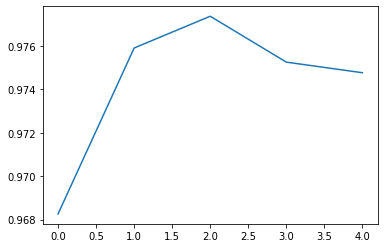

In [27]:
plt.plot(save_train_acc)
plt.show()

#### Save flowers data

In [28]:
import copy
data_dict = dict()
print(f"saving dataloaders for dataset: {data_name}")
data_dict[data_name] = {"train_loader":copy.deepcopy(train_loader),"val_loader":copy.deepcopy(val_loader)}

saving dataloaders for dataset: flowers


# Train on WikiArt data

In [29]:
data_name = "wikiart"
train_path = f"/workspace/src/CH/SOTA/data/{data_name}/train/"
test_path = f"/workspace/src/CH/SOTA/data/{data_name}/test/"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

train_dataset = torchvision.datasets.ImageFolder(train_path, transform = train_transform)
val_dataset = torchvision.datasets.ImageFolder(test_path, transform = test_transform)
num_classes = len(train_dataset.classes)
print(data_name,num_classes)
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.BATCHSIZE, shuffle=True,
        num_workers=args.WORKERS, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=args.BATCHSIZE, shuffle=True,
    num_workers=args.WORKERS, pin_memory=True)

print(f"saving dataloaders for dataset: {data_name}")
data_dict[data_name] = {"train_loader":copy.deepcopy(train_loader),"val_loader":copy.deepcopy(val_loader)}

wikiart 195
saving dataloaders for dataset: wikiart


In [30]:
import copy
model.to(device)
best_val_acc = 0.
save_train_acc = []
save_val_acc = []
save_train_loss= []
save_val_loss = []
print("Data name:",data_name)
for epoch in tqdm(range(0, args.EPOCHS + 1)):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, device, epoch,data_name)
    if epoch <26:
        print(f"epoch: {epoch} skip validation (train acc: {train_acc})")
        continue
    val_acc,val_loss = eval(val_loader, model, criterion, device,data_name)
    save_train_acc.append(train_acc)
    save_val_acc.append(val_acc)
    save_train_loss.append(train_loss)
    save_val_loss.append(val_loss)
    print(f"epoch:{epoch} train acc:{train_acc} val acc:{val_acc}")
    state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer':optimizer.state_dict(),
    'train_acc':train_acc,
    'val_acc':val_acc,   
    }

    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_model_path = (f'{experiment_path}/init_model_best_epoch{epoch}.pth')
        #print(f"epoch {epoch}: best model updated")
        print("train acc:",train_acc, "val_acc:",val_acc)
        #torch.save(state, best_model_path)
        best_model = copy.deepcopy(model)

    opt_state = {
        'optimizer': optimizer.state_dict(),
    }
    scheduler.step()
# save_experiment["init"] = {'save_train_acc':save_train_acc,'save_val_acc':save_val_acc,'save_train_loss':save_train_loss,'save_val_loss':save_val_loss}

Data name: wikiart


  0%|          | 0/31 [00:00<?, ?it/s]

training...: 0it [00:00, ?it/s]

epoch: 0 skip validation (train acc: 0.22768435392446743)


training...: 0it [00:00, ?it/s]

epoch: 1 skip validation (train acc: 0.37710064094041273)


training...: 0it [00:00, ?it/s]

epoch: 2 skip validation (train acc: 0.4455927017745233)


training...: 0it [00:00, ?it/s]

epoch: 3 skip validation (train acc: 0.4933365715346557)


training...: 0it [00:00, ?it/s]

epoch: 4 skip validation (train acc: 0.5277131069041421)


training...: 0it [00:00, ?it/s]

epoch: 5 skip validation (train acc: 0.5534553798926809)


training...: 0it [00:00, ?it/s]

epoch: 6 skip validation (train acc: 0.5792004444333035)


training...: 0it [00:00, ?it/s]

epoch: 7 skip validation (train acc: 0.599277267876048)


training...: 0it [00:00, ?it/s]

epoch: 8 skip validation (train acc: 0.6156441221295113)


training...: 0it [00:00, ?it/s]

epoch: 9 skip validation (train acc: 0.6309990397256345)


training...: 0it [00:00, ?it/s]

epoch: 10 skip validation (train acc: 0.6456128009450011)


training...: 0it [00:00, ?it/s]

epoch: 11 skip validation (train acc: 0.6651773750555724)


training...: 0it [00:00, ?it/s]

epoch: 12 skip validation (train acc: 0.6696257090695265)


training...: 0it [00:00, ?it/s]

epoch: 13 skip validation (train acc: 0.6836043928008054)


training...: 0it [00:00, ?it/s]

epoch: 14 skip validation (train acc: 0.6931487002559205)


training...: 0it [00:00, ?it/s]

epoch: 15 skip validation (train acc: 0.7024836415310384)


training...: 0it [00:00, ?it/s]

epoch: 16 skip validation (train acc: 0.7152256688658903)


training...: 0it [00:00, ?it/s]

epoch: 17 skip validation (train acc: 0.728934968069999)


training...: 0it [00:00, ?it/s]

epoch: 18 skip validation (train acc: 0.7334754232122035)


training...: 0it [00:00, ?it/s]

epoch: 19 skip validation (train acc: 0.7410949573610982)


training...: 0it [00:00, ?it/s]

epoch: 20 skip validation (train acc: 0.7478519027307347)


training...: 0it [00:00, ?it/s]

epoch: 21 skip validation (train acc: 0.7601933427262505)


training...: 0it [00:00, ?it/s]

epoch: 22 skip validation (train acc: 0.7617147371636799)


training...: 0it [00:00, ?it/s]

epoch: 23 skip validation (train acc: 0.7730037630192692)


training...: 0it [00:00, ?it/s]

epoch: 24 skip validation (train acc: 0.7777577716922253)


training...: 0it [00:00, ?it/s]

epoch: 25 skip validation (train acc: 0.7874011791558001)


training...: 0it [00:00, ?it/s]

epoch:26 train acc:0.7874807383223021 val acc:0.7210960960960962
train acc: 0.7874807383223021 val_acc: 0.7210960960960962


training...: 0it [00:00, ?it/s]

epoch:27 train acc:0.7992708473017294 val acc:0.7271959459459459
train acc: 0.7992708473017294 val_acc: 0.7271959459459459


training...: 0it [00:00, ?it/s]

epoch:28 train acc:0.8159936241064455 val acc:0.7362987987987988
train acc: 0.8159936241064455 val_acc: 0.7362987987987988


training...: 0it [00:00, ?it/s]

epoch:29 train acc:0.8210449327821522 val acc:0.7326388888888888


training...: 0it [00:00, ?it/s]

epoch:30 train acc:0.8356168207655192 val acc:0.7438063063063063
train acc: 0.8356168207655192 val_acc: 0.7438063063063063


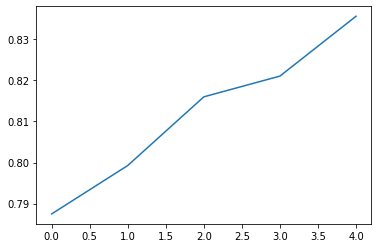

In [31]:
plt.plot(save_train_acc)
plt.show()

In [32]:
best_val_acc

0.7438063063063063

# Sketches

In [33]:
data_name = "sketches"
train_path = f"/workspace/src/CH/SOTA/data/{data_name}/train/"
test_path = f"/workspace/src/CH/SOTA/data/{data_name}/test/"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

train_dataset = torchvision.datasets.ImageFolder(train_path, transform = train_transform)
val_dataset = torchvision.datasets.ImageFolder(test_path, transform = test_transform)
num_classes = len(train_dataset.classes)
print(data_name,num_classes)
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.BATCHSIZE, shuffle=True,
        num_workers=args.WORKERS, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=args.BATCHSIZE, shuffle=True,
    num_workers=args.WORKERS, pin_memory=True)

print(f"saving dataloaders for dataset: {data_name}")
data_dict[data_name] = {"train_loader":copy.deepcopy(train_loader),"val_loader":copy.deepcopy(val_loader)}

sketches 250
saving dataloaders for dataset: sketches


In [34]:
import copy
model.to(device)
best_val_acc = 0.
save_train_acc = []
save_val_acc = []
save_train_loss= []
save_val_loss = []
print("Data name:",data_name)
for epoch in tqdm(range(0, args.EPOCHS + 1)):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, device, epoch,data_name)
    if epoch <26:
        print(f"epoch: {epoch} skip validation (train acc: {train_acc})")
        continue
    val_acc,val_loss = eval(val_loader, model, criterion, device,data_name)
    save_train_acc.append(train_acc)
    save_val_acc.append(val_acc)
    save_train_loss.append(train_loss)
    save_val_loss.append(val_loss)
    print(f"epoch:{epoch} train acc:{train_acc} val acc:{val_acc}")
    state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer':optimizer.state_dict(),
    'train_acc':train_acc,
    'val_acc':val_acc,   
    }

    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_model_path = (f'{experiment_path}/init_model_best_epoch{epoch}.pth')
        #print(f"epoch {epoch}: best model updated")
        print("train acc:",train_acc, "val_acc:",val_acc)
        #torch.save(state, best_model_path)
        best_model = copy.deepcopy(model)

    opt_state = {
        'optimizer': optimizer.state_dict(),
    }
    scheduler.step()
# save_experiment["init"] = {'save_train_acc':save_train_acc,'save_val_acc':save_val_acc,'save_train_loss':save_train_loss,'save_val_loss':save_val_loss}

Data name: sketches


  0%|          | 0/31 [00:00<?, ?it/s]

training...: 0it [00:00, ?it/s]

epoch: 0 skip validation (train acc: 0.0343125)


training...: 0it [00:00, ?it/s]

epoch: 1 skip validation (train acc: 0.178625)


training...: 0it [00:00, ?it/s]

epoch: 2 skip validation (train acc: 0.2815)


training...: 0it [00:00, ?it/s]

epoch: 3 skip validation (train acc: 0.3660625)


training...: 0it [00:00, ?it/s]

epoch: 4 skip validation (train acc: 0.42625)


training...: 0it [00:00, ?it/s]

epoch: 5 skip validation (train acc: 0.4763125)


training...: 0it [00:00, ?it/s]

epoch: 6 skip validation (train acc: 0.50675)


training...: 0it [00:00, ?it/s]

epoch: 7 skip validation (train acc: 0.5324375)


training...: 0it [00:00, ?it/s]

epoch: 8 skip validation (train acc: 0.5535625)


training...: 0it [00:00, ?it/s]

epoch: 9 skip validation (train acc: 0.580125)


training...: 0it [00:00, ?it/s]

epoch: 10 skip validation (train acc: 0.594125)


training...: 0it [00:00, ?it/s]

epoch: 11 skip validation (train acc: 0.6074375)


training...: 0it [00:00, ?it/s]

epoch: 12 skip validation (train acc: 0.6199375)


training...: 0it [00:00, ?it/s]

epoch: 13 skip validation (train acc: 0.629375)


training...: 0it [00:00, ?it/s]

epoch: 14 skip validation (train acc: 0.64475)


training...: 0it [00:00, ?it/s]

epoch: 15 skip validation (train acc: 0.6581875)


training...: 0it [00:00, ?it/s]

epoch: 16 skip validation (train acc: 0.6731875)


training...: 0it [00:00, ?it/s]

epoch: 17 skip validation (train acc: 0.673875)


training...: 0it [00:00, ?it/s]

epoch: 18 skip validation (train acc: 0.6805625)


training...: 0it [00:00, ?it/s]

epoch: 19 skip validation (train acc: 0.6879375)


training...: 0it [00:00, ?it/s]

epoch: 20 skip validation (train acc: 0.7041875)


training...: 0it [00:00, ?it/s]

epoch: 21 skip validation (train acc: 0.70775)


training...: 0it [00:00, ?it/s]

epoch: 22 skip validation (train acc: 0.7105)


training...: 0it [00:00, ?it/s]

epoch: 23 skip validation (train acc: 0.715875)


training...: 0it [00:00, ?it/s]

epoch: 24 skip validation (train acc: 0.7264375)


training...: 0it [00:00, ?it/s]

epoch: 25 skip validation (train acc: 0.7295)


training...: 0it [00:00, ?it/s]

epoch:26 train acc:0.736375 val acc:0.75725
train acc: 0.736375 val_acc: 0.75725


training...: 0it [00:00, ?it/s]

epoch:27 train acc:0.748875 val acc:0.764
train acc: 0.748875 val_acc: 0.764


training...: 0it [00:00, ?it/s]

epoch:28 train acc:0.752375 val acc:0.762


training...: 0it [00:00, ?it/s]

epoch:29 train acc:0.764125 val acc:0.7715
train acc: 0.764125 val_acc: 0.7715


training...: 0it [00:00, ?it/s]

epoch:30 train acc:0.77225 val acc:0.77075


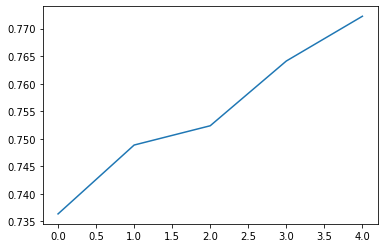

In [35]:
plt.plot(save_train_acc)
plt.show()

In [36]:
best_val_acc

0.7715

# Cars

In [37]:
data_name = "stanford_cars_cropped"
train_path = f"/workspace/src/CH/SOTA/data/{data_name}/train/"
test_path = f"/workspace/src/CH/SOTA/data/{data_name}/test/"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

train_dataset = torchvision.datasets.ImageFolder(train_path, transform = train_transform)
val_dataset = torchvision.datasets.ImageFolder(test_path, transform = test_transform)
num_classes = len(train_dataset.classes)
print(data_name,num_classes)
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.BATCHSIZE, shuffle=True,
        num_workers=args.WORKERS, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=args.BATCHSIZE, shuffle=True,
    num_workers=args.WORKERS, pin_memory=True)

print(f"saving dataloaders for dataset: {data_name}")
data_dict[data_name] = {"train_loader":copy.deepcopy(train_loader),"val_loader":copy.deepcopy(val_loader)}

stanford_cars_cropped 196
saving dataloaders for dataset: stanford_cars_cropped


In [38]:
import copy
model.to(device)
best_val_acc = 0.
save_train_acc = []
save_val_acc = []
save_train_loss= []
save_val_loss = []
print("Data name:",data_name)
for epoch in tqdm(range(0, args.EPOCHS + 1)):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, device, epoch,data_name)
    if epoch <26:
        print(f"epoch: {epoch} skip validation (train acc: {train_acc})")
        continue
    val_acc,val_loss = eval(val_loader, model, criterion, device,data_name)
    save_train_acc.append(train_acc)
    save_val_acc.append(val_acc)
    save_train_loss.append(train_loss)
    save_val_loss.append(val_loss)
    print(f"epoch:{epoch} train acc:{train_acc} val acc:{val_acc}")
    state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer':optimizer.state_dict(),
    'train_acc':train_acc,
    'val_acc':val_acc,   
    }

    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_model_path = (f'{experiment_path}/init_model_best_epoch{epoch}.pth')
        #print(f"epoch {epoch}: best model updated")
        print("train acc:",train_acc, "val_acc:",val_acc)
        #torch.save(state, best_model_path)
        best_model = copy.deepcopy(model)

    opt_state = {
        'optimizer': optimizer.state_dict(),
    }
    scheduler.step()
# save_experiment["init"] = {'save_train_acc':save_train_acc,'save_val_acc':save_val_acc,'save_train_loss':save_train_loss,'save_val_loss':save_val_loss}

Data name: stanford_cars_cropped


  0%|          | 0/31 [00:00<?, ?it/s]

training...: 0it [00:00, ?it/s]

epoch: 0 skip validation (train acc: 0.006862745098039216)


training...: 0it [00:00, ?it/s]

epoch: 1 skip validation (train acc: 0.021813725490196077)


training...: 0it [00:00, ?it/s]

epoch: 2 skip validation (train acc: 0.06850490196078432)


training...: 0it [00:00, ?it/s]

epoch: 3 skip validation (train acc: 0.11299019607843137)


training...: 0it [00:00, ?it/s]

epoch: 4 skip validation (train acc: 0.16997549019607844)


training...: 0it [00:00, ?it/s]

epoch: 5 skip validation (train acc: 0.21764705882352942)


training...: 0it [00:00, ?it/s]

epoch: 6 skip validation (train acc: 0.2667892156862745)


training...: 0it [00:00, ?it/s]

epoch: 7 skip validation (train acc: 0.31262254901960784)


training...: 0it [00:00, ?it/s]

epoch: 8 skip validation (train acc: 0.35428921568627453)


training...: 0it [00:00, ?it/s]

epoch: 9 skip validation (train acc: 0.4082107843137255)


training...: 0it [00:00, ?it/s]

epoch: 10 skip validation (train acc: 0.4420343137254902)


training...: 0it [00:00, ?it/s]

epoch: 11 skip validation (train acc: 0.47463235294117645)


training...: 0it [00:00, ?it/s]

epoch: 12 skip validation (train acc: 0.5084558823529411)


training...: 0it [00:00, ?it/s]

epoch: 13 skip validation (train acc: 0.527328431372549)


training...: 0it [00:00, ?it/s]

epoch: 14 skip validation (train acc: 0.5572303921568628)


training...: 0it [00:00, ?it/s]

epoch: 15 skip validation (train acc: 0.5887254901960784)


training...: 0it [00:00, ?it/s]

epoch: 16 skip validation (train acc: 0.6028186274509804)


training...: 0it [00:00, ?it/s]

epoch: 17 skip validation (train acc: 0.6214460784313726)


training...: 0it [00:00, ?it/s]

epoch: 18 skip validation (train acc: 0.6368872549019607)


training...: 0it [00:00, ?it/s]

epoch: 19 skip validation (train acc: 0.6664215686274509)


training...: 0it [00:00, ?it/s]

epoch: 20 skip validation (train acc: 0.6783088235294118)


training...: 0it [00:00, ?it/s]

epoch: 21 skip validation (train acc: 0.6811274509803922)


training...: 0it [00:00, ?it/s]

epoch: 22 skip validation (train acc: 0.6943627450980392)


training...: 0it [00:00, ?it/s]

epoch: 23 skip validation (train acc: 0.7091911764705883)


training...: 0it [00:00, ?it/s]

epoch: 24 skip validation (train acc: 0.7235294117647059)


training...: 0it [00:00, ?it/s]

epoch: 25 skip validation (train acc: 0.7264705882352941)


training...: 0it [00:00, ?it/s]

epoch:26 train acc:0.7446078431372549 val acc:0.7748429233592654
train acc: 0.7446078431372549 val_acc: 0.7748429233592654


training...: 0it [00:00, ?it/s]

epoch:27 train acc:0.7567401960784313 val acc:0.7824900793650794
train acc: 0.7567401960784313 val_acc: 0.7824900793650794


training...: 0it [00:00, ?it/s]

epoch:28 train acc:0.7633578431372549 val acc:0.7845844356786638
train acc: 0.7633578431372549 val_acc: 0.7845844356786638


training...: 0it [00:00, ?it/s]

epoch:29 train acc:0.7827205882352941 val acc:0.7933338845059985
train acc: 0.7827205882352941 val_acc: 0.7933338845059985


training...: 0it [00:00, ?it/s]

epoch:30 train acc:0.7938725490196078 val acc:0.8010774912342192
train acc: 0.7938725490196078 val_acc: 0.8010774912342192


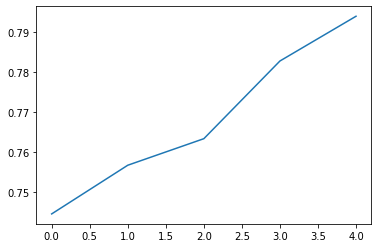

In [39]:
plt.plot(save_train_acc)
plt.show()

In [40]:
best_val_acc

0.8010774912342192

# CUB

In [41]:

data_name = "cubs_cropped"#"stanford_cars_cropped"
train_path = f"/workspace/src/CH/SOTA/data/{data_name}/train/"
test_path = f"/workspace/src/CH/SOTA/data/{data_name}/test/"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

train_dataset = torchvision.datasets.ImageFolder(train_path, transform = train_transform)
val_dataset = torchvision.datasets.ImageFolder(test_path, transform = test_transform)
num_classes = len(train_dataset.classes)
print(data_name,num_classes)
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.BATCHSIZE, shuffle=True,
        num_workers=args.WORKERS, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=args.BATCHSIZE, shuffle=True,
    num_workers=args.WORKERS, pin_memory=True)

print(f"saving dataloaders for dataset: {data_name}")
data_dict[data_name] = {"train_loader":copy.deepcopy(train_loader),"val_loader":copy.deepcopy(val_loader)}

cubs_cropped 200
saving dataloaders for dataset: cubs_cropped


In [42]:
import copy
model.to(device)
best_val_acc = 0.
save_train_acc = []
save_val_acc = []
save_train_loss= []
save_val_loss = []
print("Data name:",data_name)
for epoch in tqdm(range(0, args.EPOCHS + 1)):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, device, epoch,data_name)
    if epoch <26:
        print(f"epoch: {epoch} skip validation (train acc: {train_acc})")
        continue
    val_acc,val_loss = eval(val_loader, model, criterion, device,data_name)
    save_train_acc.append(train_acc)
    save_val_acc.append(val_acc)
    save_train_loss.append(train_loss)
    save_val_loss.append(val_loss)
    print(f"epoch:{epoch} train acc:{train_acc} val acc:{val_acc}")
    state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer':optimizer.state_dict(),
    'train_acc':train_acc,
    'val_acc':val_acc,   
    }

    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_model_path = (f'{experiment_path}/init_model_best_epoch{epoch}.pth')
        #print(f"epoch {epoch}: best model updated")
        print("train acc:",train_acc, "val_acc:",val_acc)
        #torch.save(state, best_model_path)
        best_model = copy.deepcopy(model)

    opt_state = {
        'optimizer': optimizer.state_dict(),
    }
    scheduler.step()
# save_experiment["init"] = {'save_train_acc':save_train_acc,'save_val_acc':save_val_acc,'save_train_loss':save_train_loss,'save_val_loss':save_val_loss}

Data name: cubs_cropped


  0%|          | 0/31 [00:00<?, ?it/s]

training...: 0it [00:00, ?it/s]

epoch: 0 skip validation (train acc: 0.005152925531914893)


training...: 0it [00:00, ?it/s]

epoch: 1 skip validation (train acc: 0.010305851063829786)


training...: 0it [00:00, ?it/s]

epoch: 2 skip validation (train acc: 0.018284574468085107)


training...: 0it [00:00, ?it/s]

epoch: 3 skip validation (train acc: 0.025099734042553192)


training...: 0it [00:00, ?it/s]

epoch: 4 skip validation (train acc: 0.03856382978723404)


training...: 0it [00:00, ?it/s]

epoch: 5 skip validation (train acc: 0.05339095745473466)


training...: 0it [00:00, ?it/s]

epoch: 6 skip validation (train acc: 0.0678191489361702)


training...: 0it [00:00, ?it/s]

epoch: 7 skip validation (train acc: 0.08713430851856445)


training...: 0it [00:00, ?it/s]

epoch: 8 skip validation (train acc: 0.10226063830579848)


training...: 0it [00:00, ?it/s]

epoch: 9 skip validation (train acc: 0.12257313831372464)


training...: 0it [00:00, ?it/s]

epoch: 10 skip validation (train acc: 0.13819813831372463)


training...: 0it [00:00, ?it/s]

epoch: 11 skip validation (train acc: 0.15744680851856444)


training...: 0it [00:00, ?it/s]

epoch: 12 skip validation (train acc: 0.16974734043345807)


training...: 0it [00:00, ?it/s]

epoch: 13 skip validation (train acc: 0.18603723405047934)


training...: 0it [00:00, ?it/s]

epoch: 14 skip validation (train acc: 0.20382313830579848)


training...: 0it [00:00, ?it/s]

epoch: 15 skip validation (train acc: 0.21396276596537295)


training...: 0it [00:00, ?it/s]

epoch: 16 skip validation (train acc: 0.2309175531994155)


training...: 0it [00:00, ?it/s]

epoch: 17 skip validation (train acc: 0.24744015963787727)


training...: 0it [00:00, ?it/s]

epoch: 18 skip validation (train acc: 0.2526928191568623)


training...: 0it [00:00, ?it/s]

epoch: 19 skip validation (train acc: 0.2710438830421326)


training...: 0it [00:00, ?it/s]

epoch: 20 skip validation (train acc: 0.2801529255477672)


training...: 0it [00:00, ?it/s]

epoch: 21 skip validation (train acc: 0.29541223405047934)


training...: 0it [00:00, ?it/s]

epoch: 22 skip validation (train acc: 0.2999667553825581)


training...: 0it [00:00, ?it/s]

epoch: 23 skip validation (train acc: 0.3280252659732991)


training...: 0it [00:00, ?it/s]

epoch: 24 skip validation (train acc: 0.3355385638931964)


training...: 0it [00:00, ?it/s]

epoch: 25 skip validation (train acc: 0.34029255319941554)


training...: 0it [00:00, ?it/s]

epoch:26 train acc:0.35684840428702375 val acc:0.38804945054945056
train acc: 0.35684840428702375 val_acc: 0.38804945054945056


training...: 0it [00:00, ?it/s]

epoch:27 train acc:0.3629986702444706 val acc:0.38804945054945056


training...: 0it [00:00, ?it/s]

epoch:28 train acc:0.3750332446887772 val acc:0.39354395604395603
train acc: 0.3750332446887772 val_acc: 0.39354395604395603


training...: 0it [00:00, ?it/s]

epoch:29 train acc:0.3779255319783028 val acc:0.4028159340659341
train acc: 0.3779255319783028 val_acc: 0.4028159340659341


training...: 0it [00:00, ?it/s]

epoch:30 train acc:0.3833444149015432 val acc:0.40024038461538464


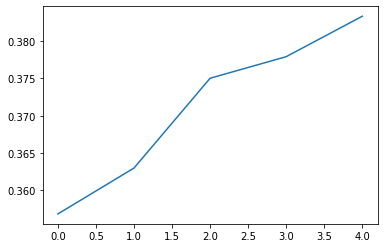

In [43]:
plt.plot(save_train_acc)
plt.show()

In [44]:
best_val_acc

0.4028159340659341

# [ Evaluate on all data ]

In [45]:
for data_name, data_loaders in data_dict.items():
#     print("data:",data_name)
    val_loader = data_loaders["val_loader"]
    val_acc,val_loss = eval(val_loader, model, criterion, device,data_name)
    print("data:",data_name,"val_acc:",val_acc)

data: flowers val_acc: 0.010265544056892395
data: wikiart val_acc: 0.030874624624624626
data: sketches val_acc: 0.013
data: stanford_cars_cropped val_acc: 0.1236359126984127
data: cubs_cropped val_acc: 0.4028159340659341
